<a href="https://colab.research.google.com/github/dD2405/Intro_to_TensorFlow/blob/master/5_Dogs_vs_Cats_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## Understanding our Data

In [36]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("-------------------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
-------------------------------------------------------------
Total training images: 2000
Total validation images: 1000


# Setting the Model Parameters 

In [0]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk and will apply rescaling and will resize them into required dimensions using single line of code.

# Data Augmentation 

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    s = axes.flatten()

    for img,ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


### Flipping the Image horizontally

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [28]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size = BATCH_SIZE,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

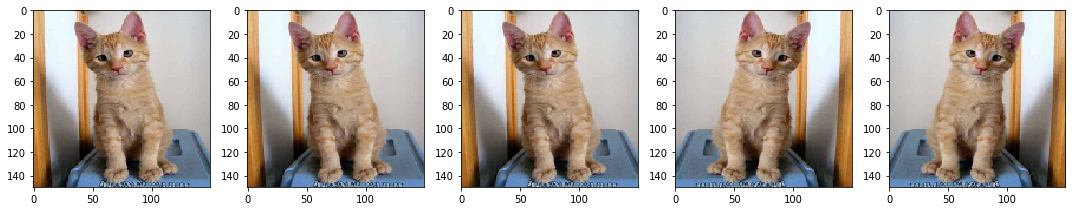

In [29]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together 

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.


In [34]:
image_gen_train = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    fill_mode = 'nearest'
)

train_data_gen = image_gen_train.flow_from_directory(batch_size = BATCH_SIZE,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.


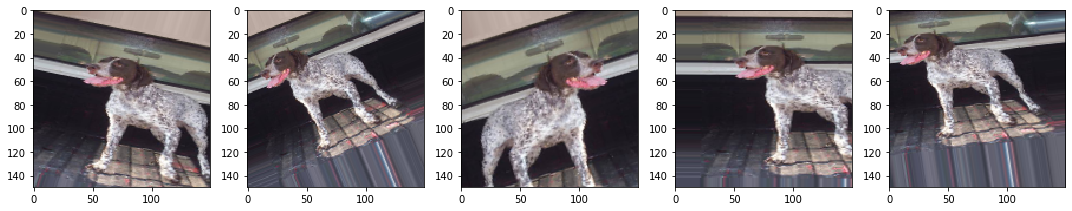

In [35]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [39]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory = validation_dir,
                                                 target_size = (IMG_SHAPE,IMG_SHAPE),
                                                 class_mode = 'binary'
                                                 )

Found 1000 images belonging to 2 classes.


# Model Creation 

### Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [0]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape= (IMG_SHAPE,IMG_SHAPE,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(2, activation='softmax')
                                    ])

### Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Model Summary

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

### Train the Model

In [50]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 10 steps
Epoch 1/100
20/20 [==============================] - 23s 1s/step - loss: 0.7267 - accuracy: 0.4950 - val_loss: 0.6926 - val_accuracy: 0.6100
Epoch 2/100
20/20 [==============================] - 19s 944ms/step - loss: 0.6927 - accuracy: 0.5075 - val_loss: 0.6922 - val_accuracy: 0.5170
Epoch 3/100
20/20 [==============================] - 19s 939ms/step - loss: 0.6875 - accuracy: 0.5455 - val_loss: 0.6806 - val_accuracy: 0.5500
Epoch 4/100
20/20 [==============================] - 19s 946ms/step - loss: 0.6738 - accuracy: 0.5775 - val_loss: 0.6677 - val_accuracy: 0.5640
Epoch 5/100
20/20 [==============================] - 19s 947ms/step - loss: 0.6557 - accuracy: 0.6160 - val_loss: 0.6226 - val_accuracy: 0.6510
Epoch 6/100
20/20 [==============================] - 19s 941ms/step - loss: 0.6383 - accuracy: 0.6350 - val_loss: 0.6139 - val_accuracy: 0.6800
Epoch 7/100
20/20 [============================

### Visualizing results of the training

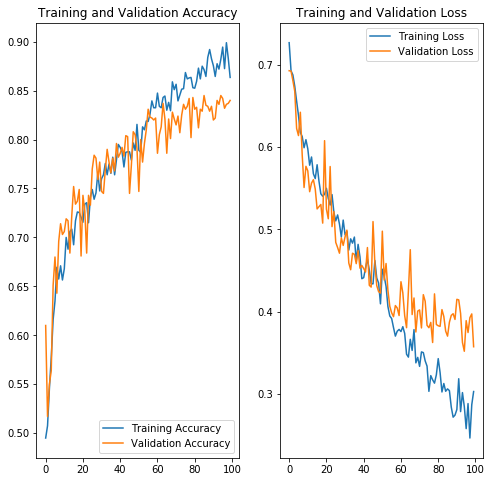

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()